From: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb

In [1]:
!pip install monai

In [2]:
import numpy as np
import os
import monai
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from monai.data import DataLoader,pad_list_data_collate,Dataset
from monai.transforms import Compose,LoadImaged,EnsureChannelFirstd,Transposed,RandSpatialCropd,ToTensord

In [21]:
def load_images(directory_pelvis: str, device=None):
    """
    Load MRI and CT images, preprocess them, and return preprocessed pairs on the specified device.

    Args:
        directory_pelvis (str): Path to the dataset directory.
        device (torch.device): Device to which the tensors will be moved (e.g., 'cuda' or 'cpu').

    Returns:
        list: A list of dictionaries containing preprocessed 'mr' and 'ct' images.
    """
    
    # Default to CPU if no device is specified
    if device is None:
        device = torch.device("cpu")

    dataset = []
    processed_images = []
    
    for folder_patient in os.listdir(directory_pelvis):
        patient_path = os.path.join(directory_pelvis, folder_patient)
        #print(patient_path)

        # Load MRI and CT images for each patient
        mri_processed_path = os.path.join(patient_path, "mr_processed.nii.gz") 
        ct_processed_path = os.path.join(patient_path, "ct_processed.nii.gz")

        if os.path.exists(mri_processed_path) and os.path.exists(ct_processed_path):
            dataset.append({"mr": mri_processed_path,"ct": ct_processed_path})

    transforms = Compose([
        LoadImaged(keys=["mr", "ct"]),
        EnsureChannelFirstd(keys=["mr", "ct"]),
        # Permute dimensions of tensors to match the desired order
        # [C, D, W, H]->[C, H, W, D]
        Transposed(keys=["mr", "ct"], indices=(0, 3, 2, 1)),
        RandSpatialCropd(keys=["mr", "ct"], roi_size=(200, 200, 20), random_size=False), # Random Crop
        ToTensord(keys=["mr", "ct"])
    ])  

    monai_dataset = Dataset(data=dataset, transform=transforms)
    train_dataset, val_dataset = torch.utils.data.random_split(monai_dataset, [0.8, 0.2])
    
    # The paper states that batch_size=1 provides better results
    train_dl = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate) # to handle tensors of different sizes
    val_dl = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=pad_list_data_collate)
    
    return train_dataset,val_dataset, train_dl, val_dl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset,val_dataset, train_dl, val_dl = load_images("C:\\Users\\catar\\OneDrive - Universidade de Coimbra\\Ambiente de Trabalho\\Master Thesis\\Code\\mythesisprojects\\processed_data", device=device)


In [22]:
for real_images in train_dl:
    print("MR:",real_images['mr'].shape)
    print("CT:",real_images['ct'].shape)
    
for real_images in val_dl:
    print("MR:",real_images['mr'].shape)
    print("CT:",real_images['ct'].shape)

MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])
MR: torch.Size([1, 1, 200, 200, 20])
CT: torch.Size([1, 1, 200, 200, 20])


(1, 1, 200, 200, 20)
(200, 200)


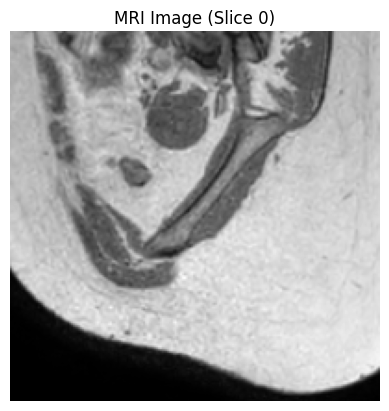

In [23]:
dataiter = iter(train_dl)
images = next(dataiter)

mr_images = images["mr"].cpu().numpy() 
ct_images = images["ct"].cpu().numpy() 
print(mr_images.shape)

# -> [B, C, H, W, D]
img = mr_images[0,0,:,:,0] # 1st image in the batch, 1st channel, 1st slice
print(img.shape)
plt.imshow(img, cmap='gray')
plt.title("MRI Image (Slice 0)")
plt.axis('off')  # Hide axes for better presentation
plt.show()

# Encoder

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers.

# Decoder

The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. I want to get a 256x256 image out from the decoder so we need to work our way back up from the compressed representation.

* Transpose convolutions:

This decoder uses transposed convolutional layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer.

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In this Distill article from Augustus Odena, et al, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer.

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        return encoded

In [44]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3, 3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded

In [35]:
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [41]:
input_image = torch.randn(1,1,200,200).to(device)
model = AutoEncoder().to(device)
output_image = model(input_image)

print(output_image.shape)

torch.Size([1, 1, 204, 204])


In [42]:
# specify loss function
criterion = nn.MSELoss().to(device)

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    model.train()
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for batch in train_dl:
        
        # Model inputs
        images_mri = batch["mr"].to(device)  # Shape: [B, C, H, W, D]
        images_ct = batch["ct"].to(device)  # Shape: [B, C, H, W, D]

        image_mri = images_mri[:,:,:,:,4]
        image_ct = images_ct[:,:,:,:,4]
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        preds = model(image_mri)
        
        # calculate the loss
        loss = criterion(preds, image_ct)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()
            
    # print avg training statistics 
    train_loss = train_loss/len(train_dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

    ######################
    # validate the model #
    ######################

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dl:
            # Model inputs
            images_mri = batch["mr"].to(device)  # Shape: [B, C, H, W, D]
            images_ct = batch["ct"].to(device)  # Shape: [B, C, H, W, D]
    
            image_mri = images_mri[:,:,:,:,4]
            image_ct = images_ct[:,:,:,:,4]

            preds = model(image_mri)
            loss = criterion(preds, image_ct)
            
            val_loss += loss.item()
            
    # print avg validation statistics 
    val_loss = val_loss/len(val_dl)
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(
        epoch, 
        val_loss
        ))

C:\Users\catar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_tensor.py:1437: UserWarning: Using a target size (torch.Size([1, 1, 200, 200])) that is different to the input size (torch.Size([1, 1, 204, 204])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


RuntimeError: The size of tensor a (204) must match the size of tensor b (200) at non-singleton dimension 3

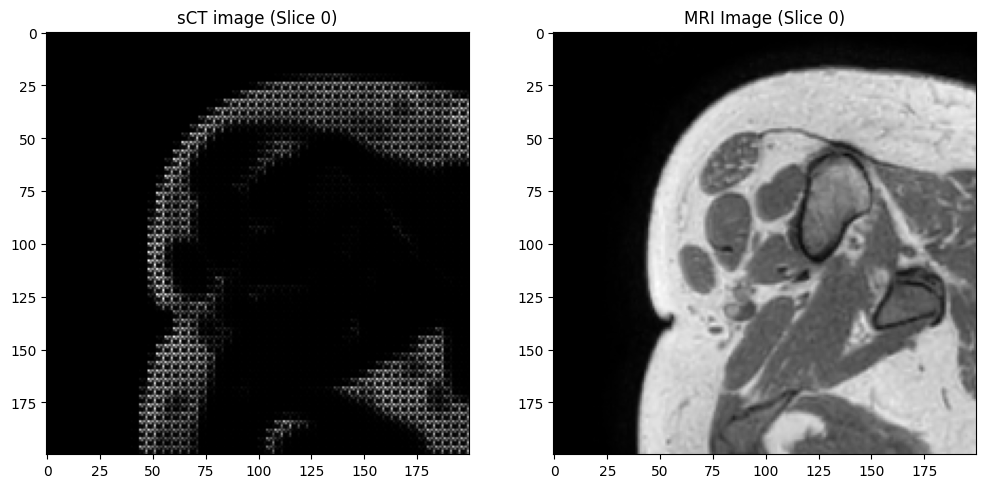

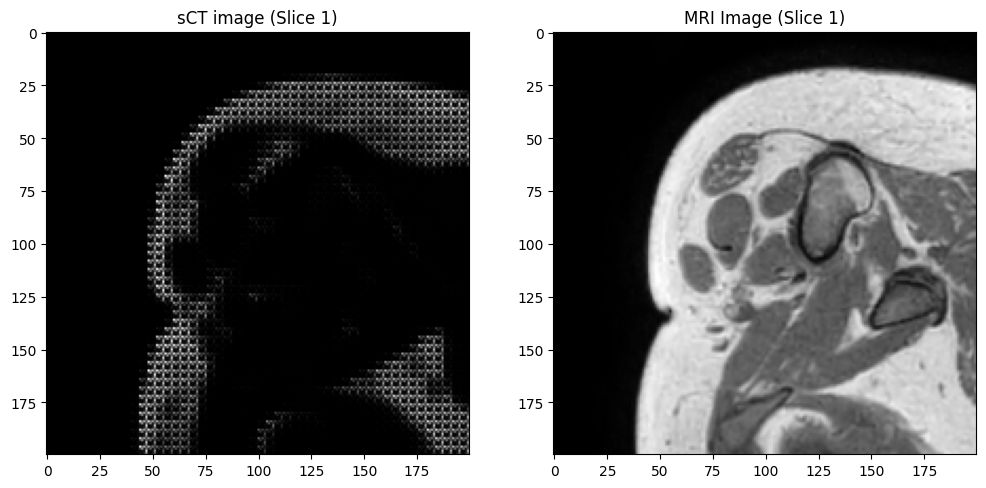

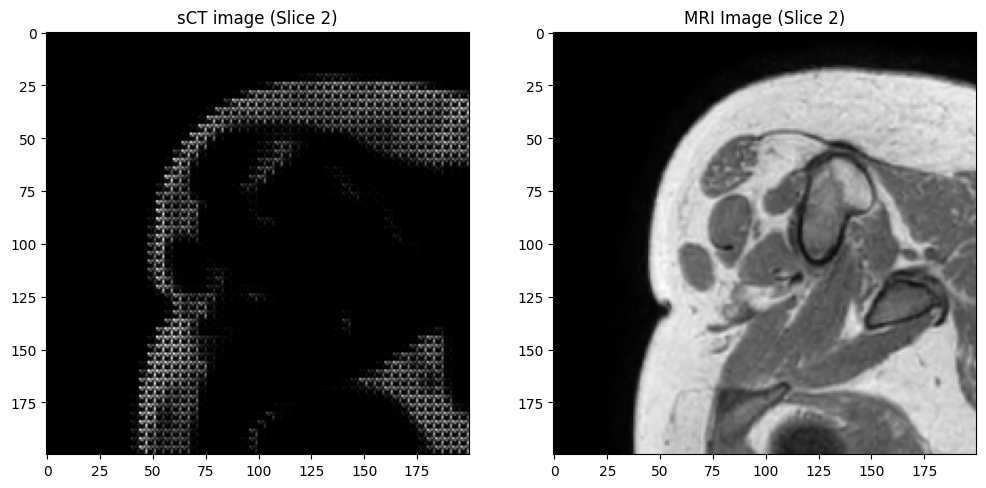

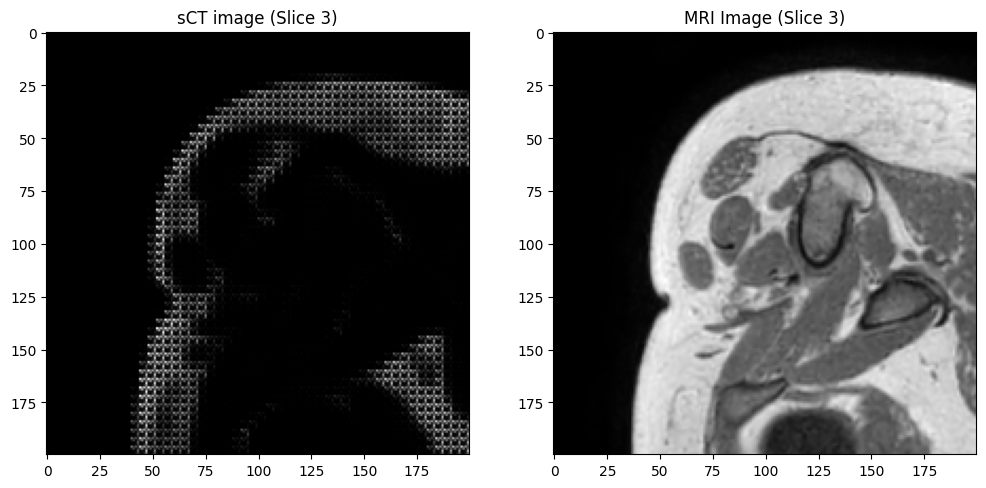

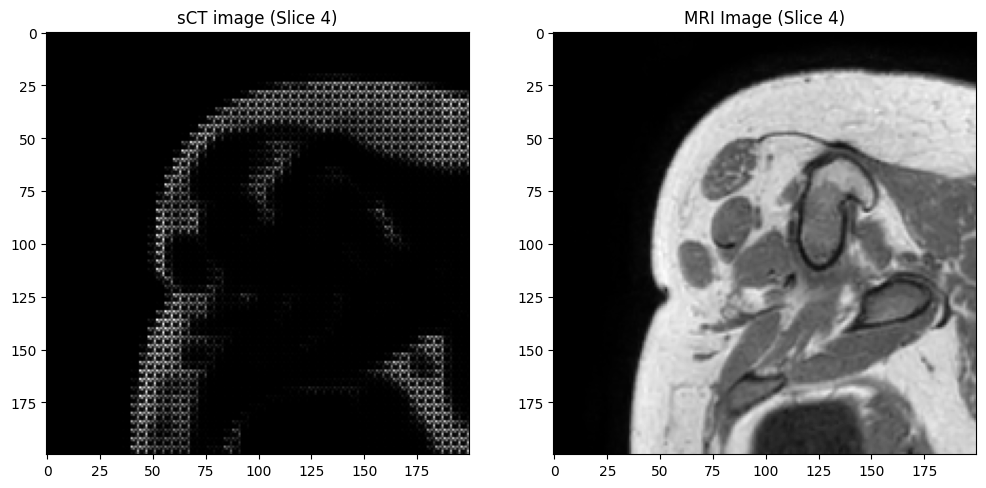

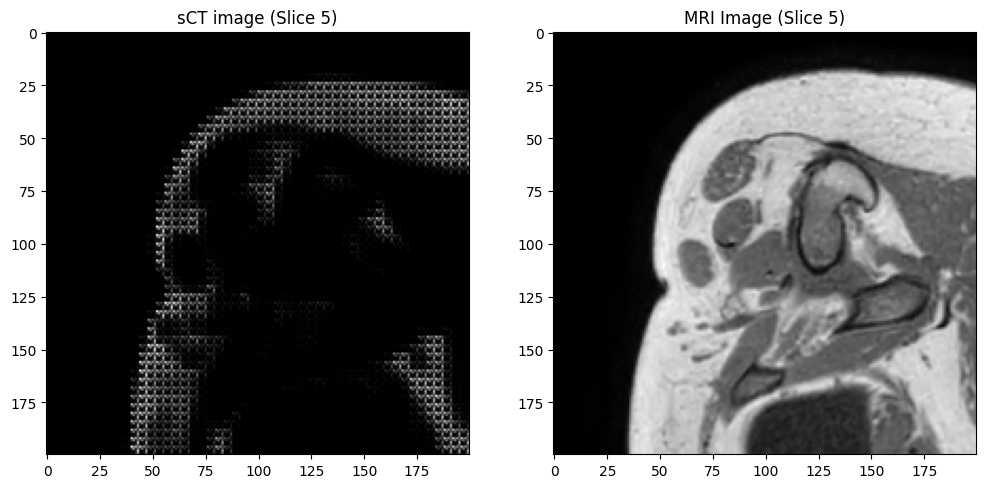

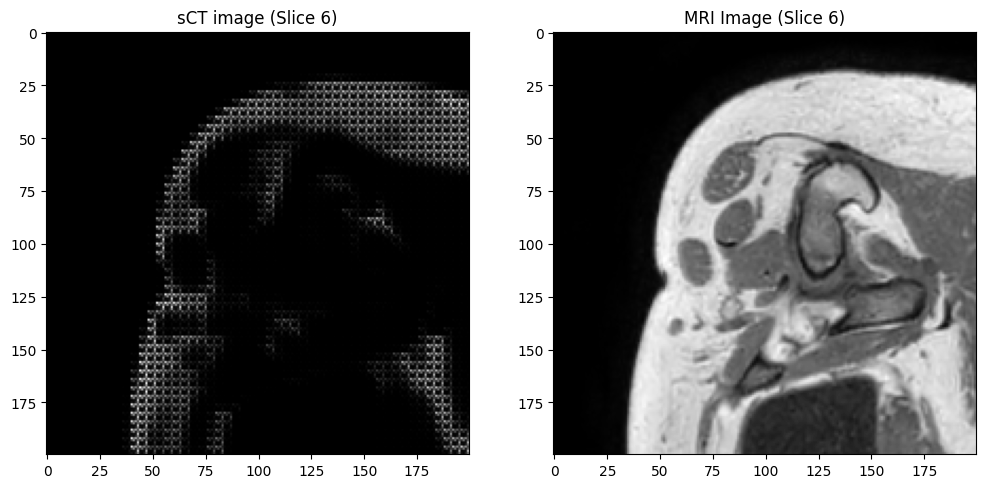

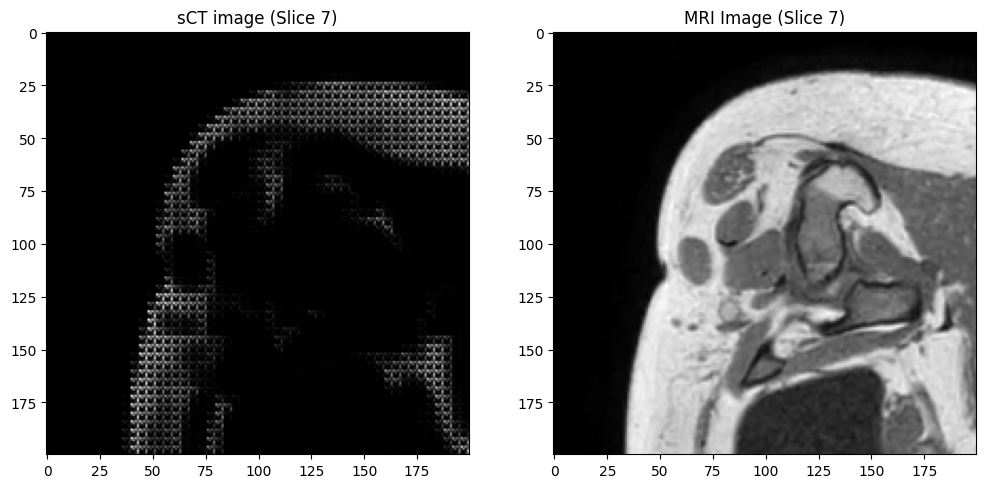

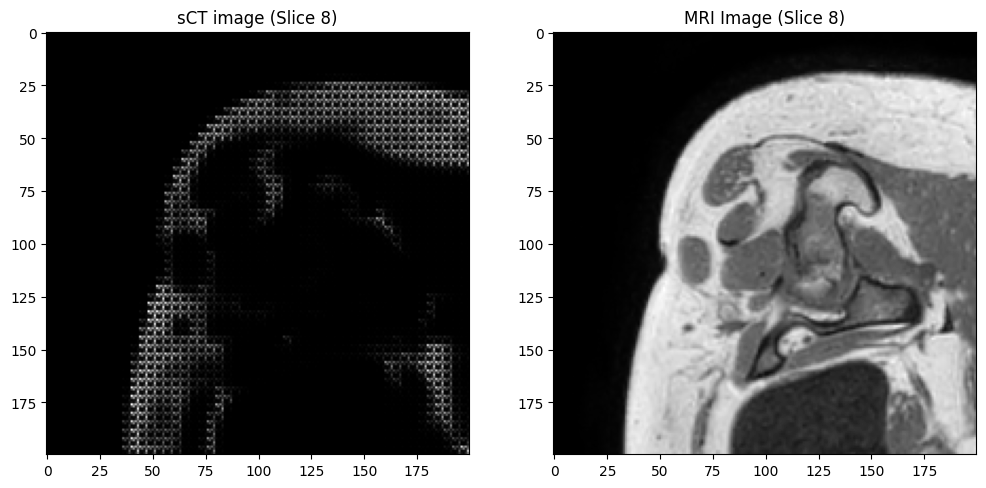

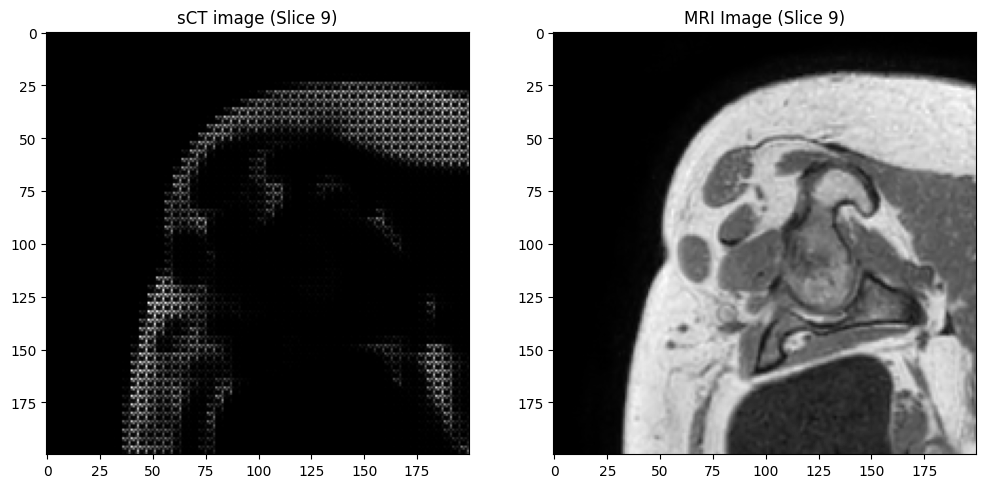

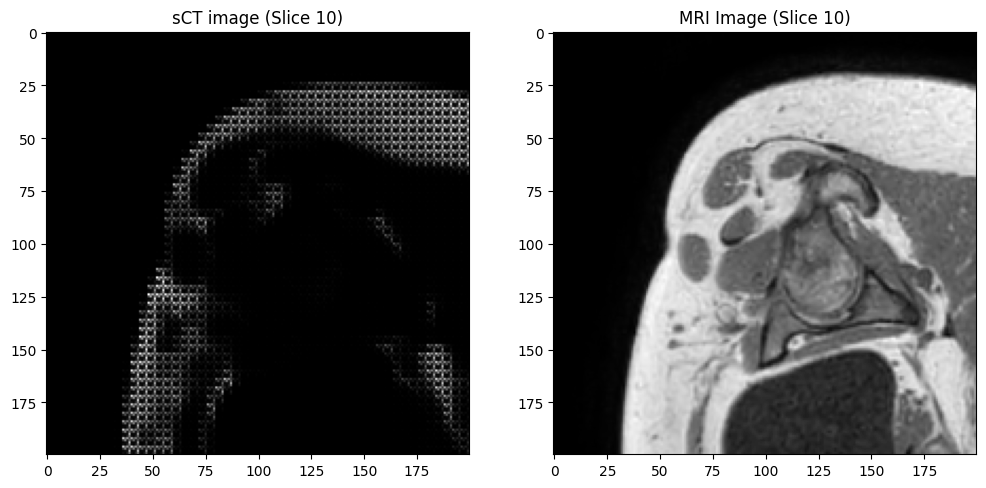

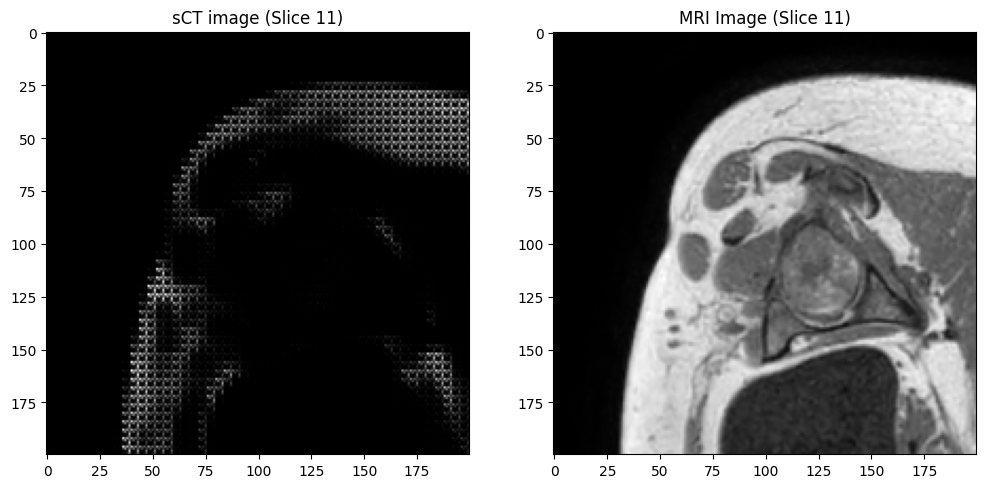

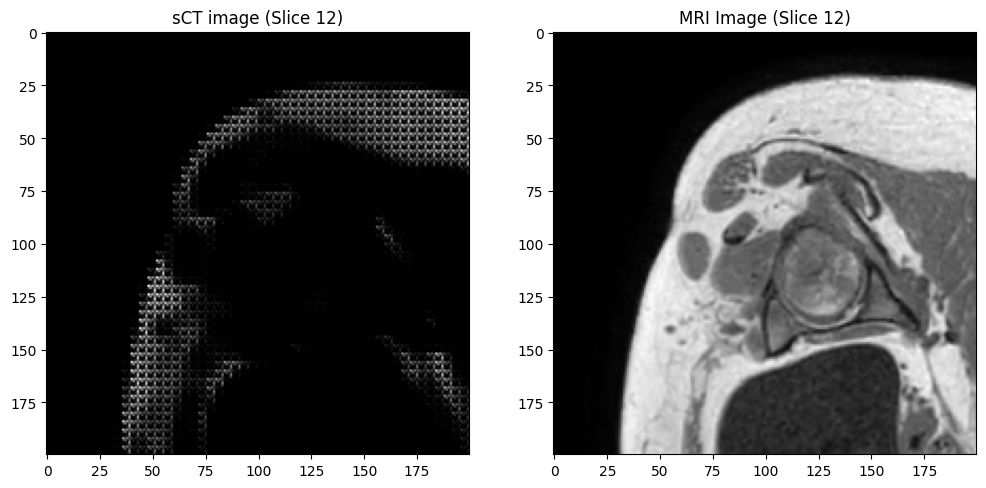

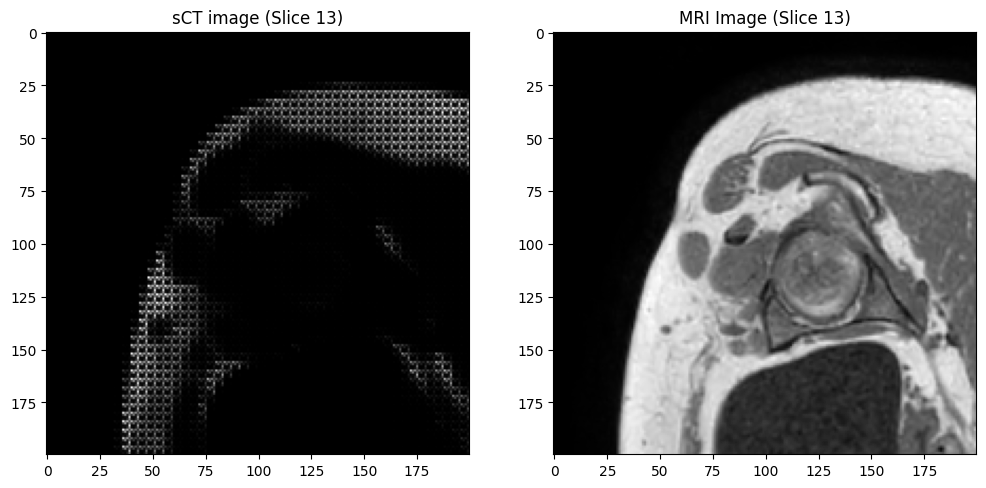

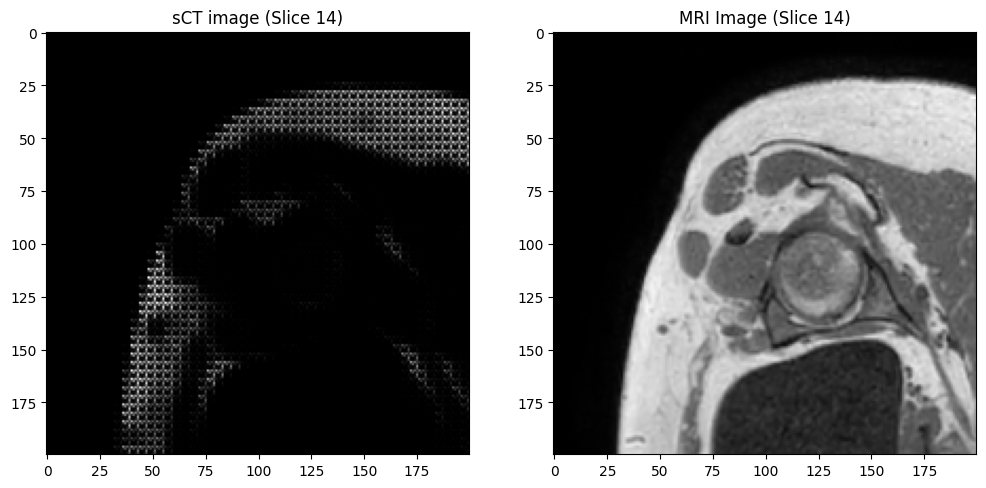

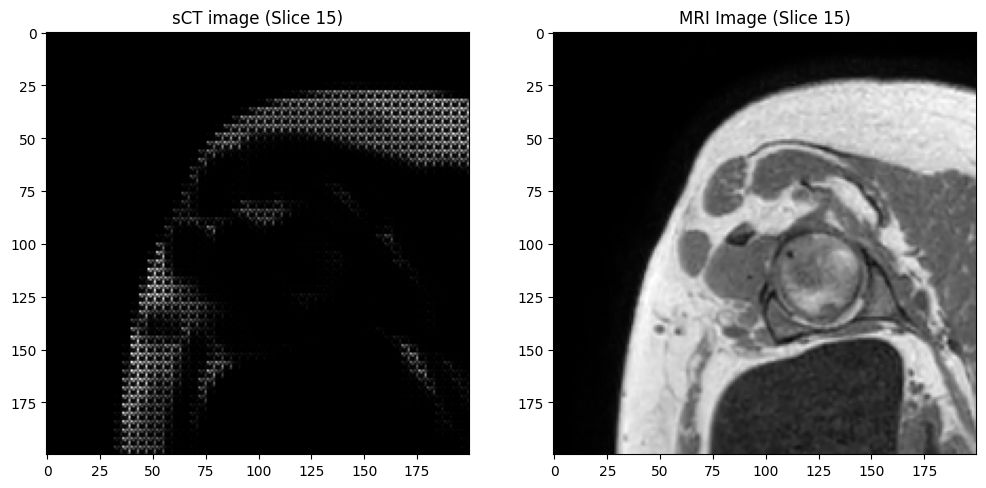

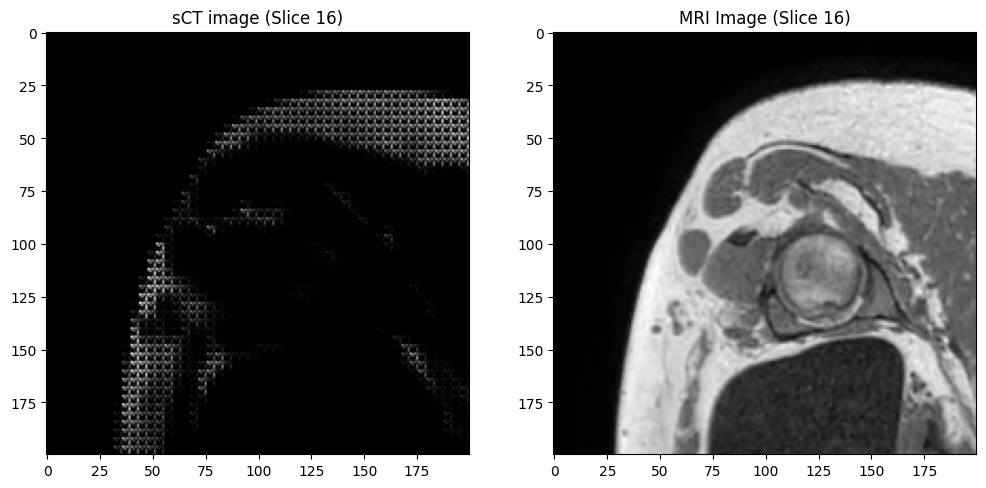

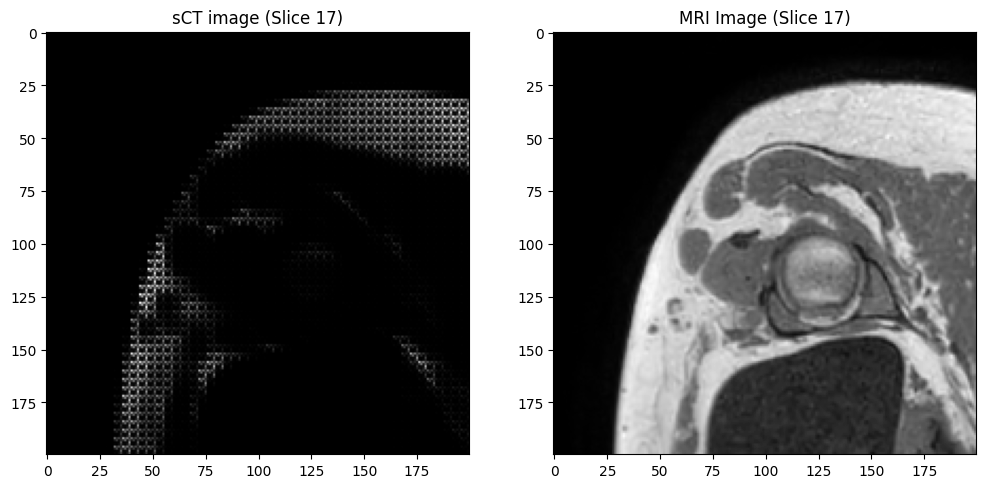

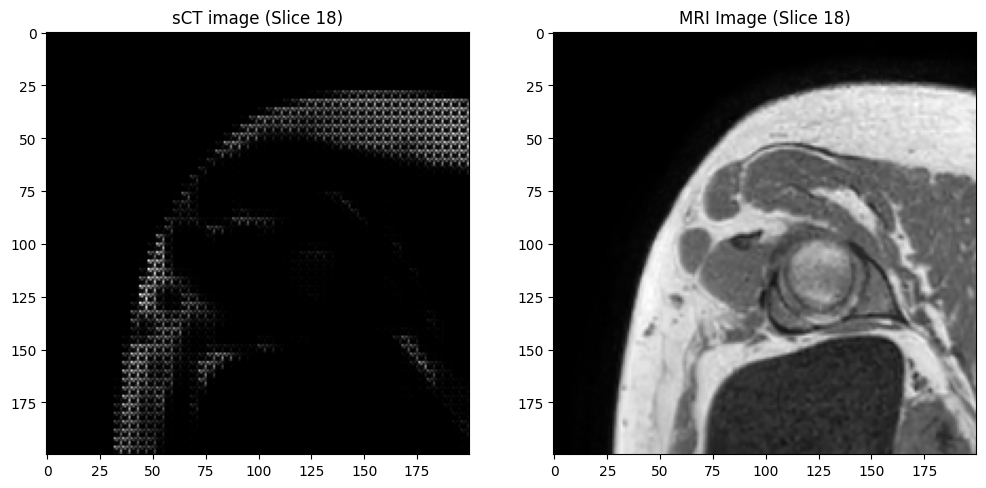

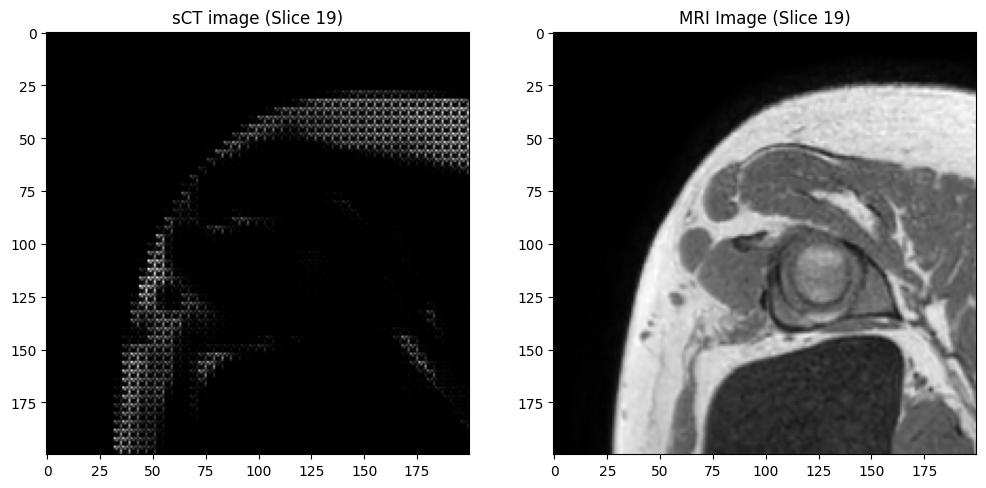

In [27]:
# obtain one batch of validation images
dataiter = iter(val_dl)
images = next(dataiter)

mr_images = images["mr"].cpu()
ct_images = images["ct"].cpu()

for i in range(mr_images.shape[-1]):
    # -> [B, C, H, W, D]
    img = mr_images[:,:,:,:,i] # 1st slice
    
    # get sample outputs
    output = model(img)
    
    output_img = output.detach().cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(output_img[0,0,:,:], cmap='gray')
    axes[0].set_title(f"sCT image (Slice {i})")
    
    axes[1].imshow(img[0,0,:,:], cmap='gray')
    axes[1].set_title(f"MRI Image (Slice {i})")
    
    plt.show()